## Import libraries

In [1]:
import numpy as np
import pandas as pd
from Logistic_Regression.models.logistic_regression import (LogisticRegression as BinaryRegression, 
                                                            MultinomialRegression)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, auc, RocCurveDisplay)
from utils.plot import Plot
import seaborn as sns
import matplotlib.pyplot as plt
from Logistic_Regression.models.logistic_metrics import LogisticMetrics
from Logistic_Regression.models.roc_curve import RocCurvePlot

## Set display options

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("expand_frame_repr", False)

## Load and inspect the dataset

In [3]:
df = pd.read_csv("../data/titanic.csv")
print(df.head())
print(df.info())

   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data

## Drop unnecessary columns

In [4]:
df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [5]:
print(df.head())
print(df.info())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
None


## Check for NaN values

In [6]:
print(df.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


## Inspect columns that can be categorical

In [7]:
unique_sibsp = np.sort(df["SibSp"].unique())
print(unique_sibsp)

[0 1 2 3 4 5 8]


In [8]:
unique_parch = np.sort(df["Parch"].unique())
print(unique_parch)

[0 1 2 3 4 5 6]


## Transform columns into categorical features

In [9]:
df["Survived"] = df["Survived"].apply(lambda x: "yes" if x == 1 else "no")
df["Pclass"] = df["Pclass"].apply(lambda x: "First" if x == 1 else "Second" if x == 2 else "Third")
df["SibSp"] = df["SibSp"].astype("str")
df["Parch"] = df["Parch"].astype("str")

## Data distribution

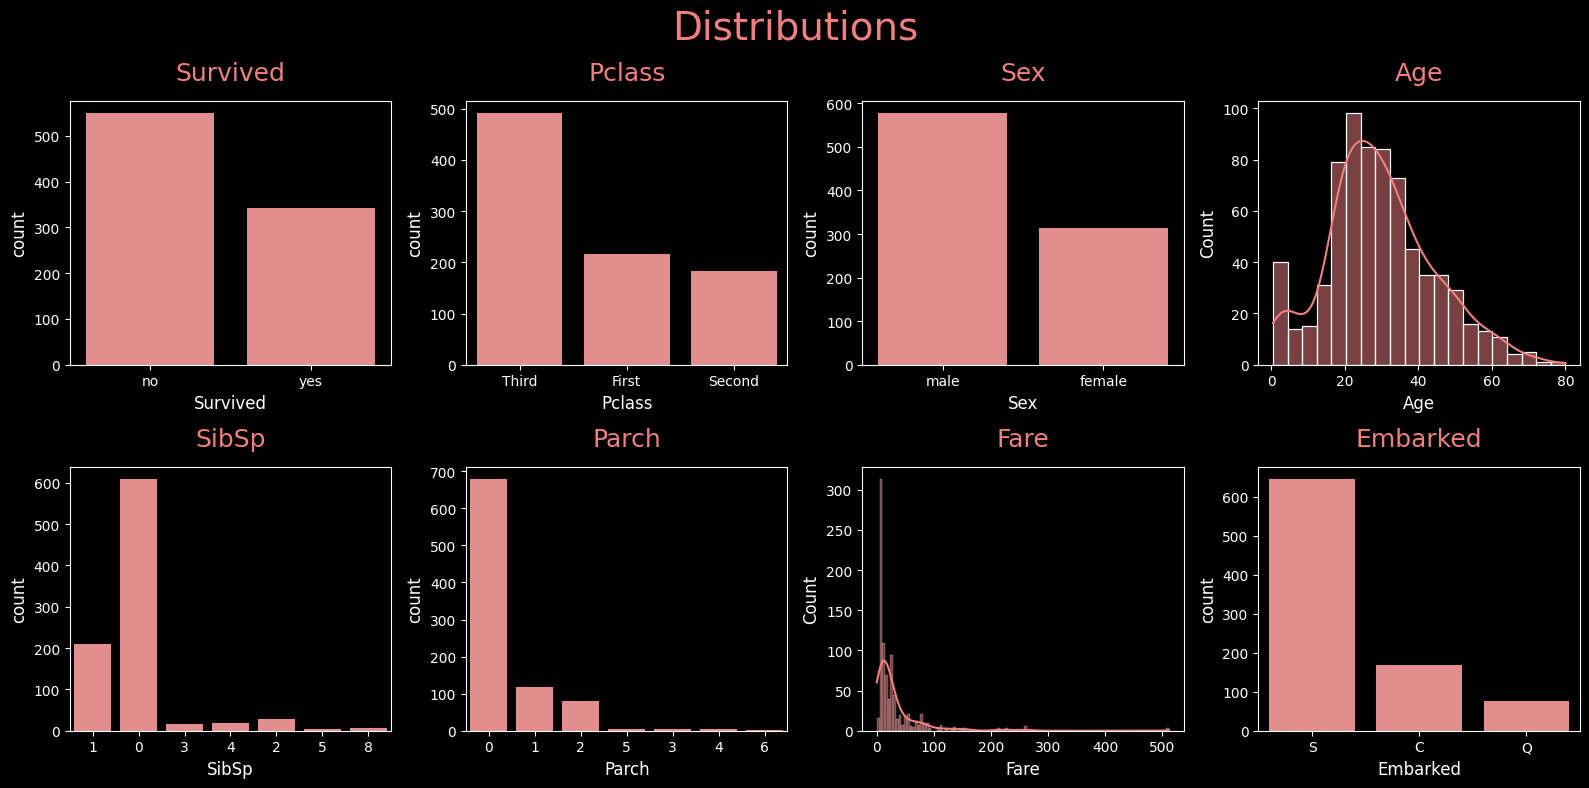

In [10]:
Plot.set_plot_params()
Plot.histplot(data=df, rows=2, columns=4, color="lightcoral")

## Distribution of Age

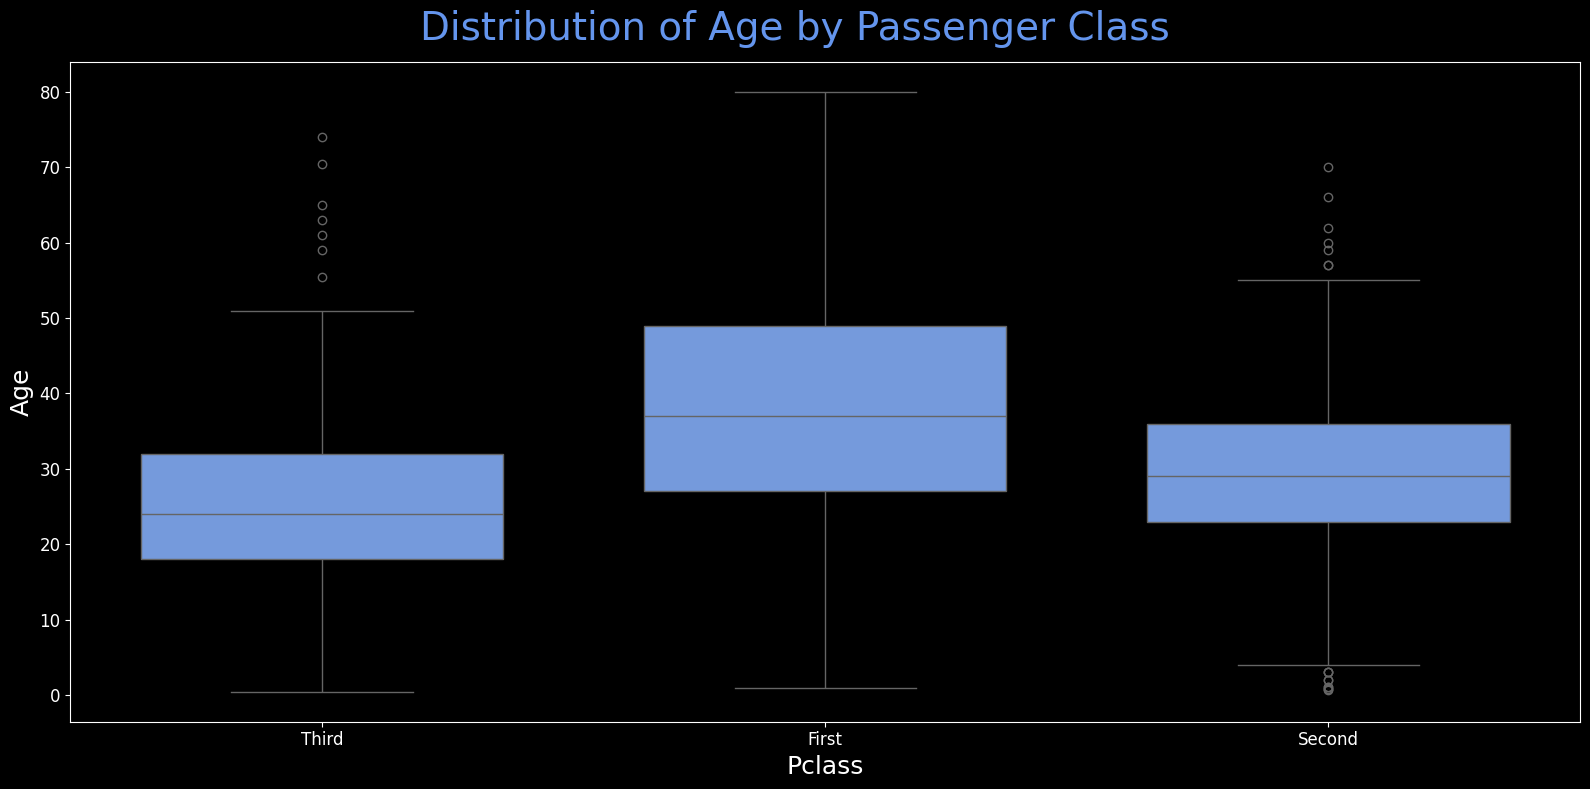

In [11]:
sns.boxplot(data=df, x="Pclass", y="Age", gap=0.1, color="cornflowerblue")

plt.suptitle(t="Distribution of Age by Passenger Class", color="cornflowerblue")
plt.xlabel(xlabel="Pclass", fontsize=18)
plt.ylabel(ylabel="Age", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

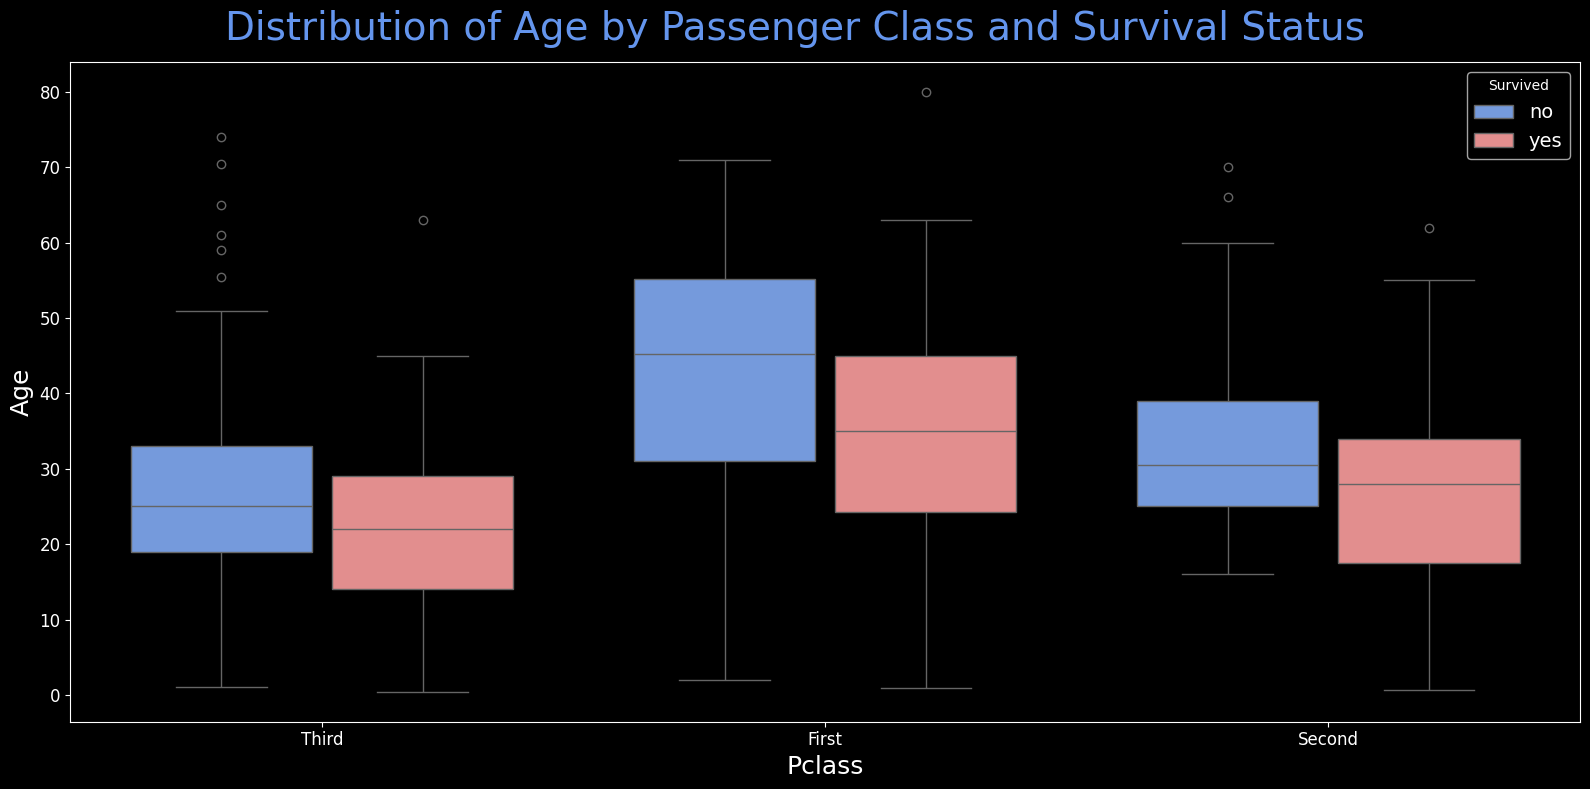

In [12]:
sns.boxplot(data=df, x="Pclass", y="Age", hue="Survived", gap=0.1, palette=["cornflowerblue", "lightcoral"])

plt.suptitle(t="Distribution of Age by Passenger Class and Survival Status", color="cornflowerblue")
plt.xlabel(xlabel="Pclass", fontsize=18)
plt.ylabel(ylabel="Age", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The age distribution varies across different passenger classes. In the Third class, there are more younger passengers compared to the Second class, while the First class has a higher proportion of older passengers than both the First and Second classes. To account for these differences, I will impute the missing values in the Age column using the mean age calculated within each passenger class (Pclass).

## Find the Age mean across Passenger Class

In [13]:
df.groupby(by=["Pclass"])["Age"].mean()


Pclass
First     38.233441
Second    29.877630
Third     25.140620
Name: Age, dtype: float64

## Fill Age nan values with corresponding mean

In [14]:
df["Age"] = df.groupby(by=["Pclass"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [15]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

## Fill Embarked nan values

Since the majority of passengers embarked from 'S', I will fill the missing values in the 'Embarked' column with 'S'.

In [16]:
df["Embarked"] = df["Embarked"].fillna("S")

In [17]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Data distributions by "Survived"

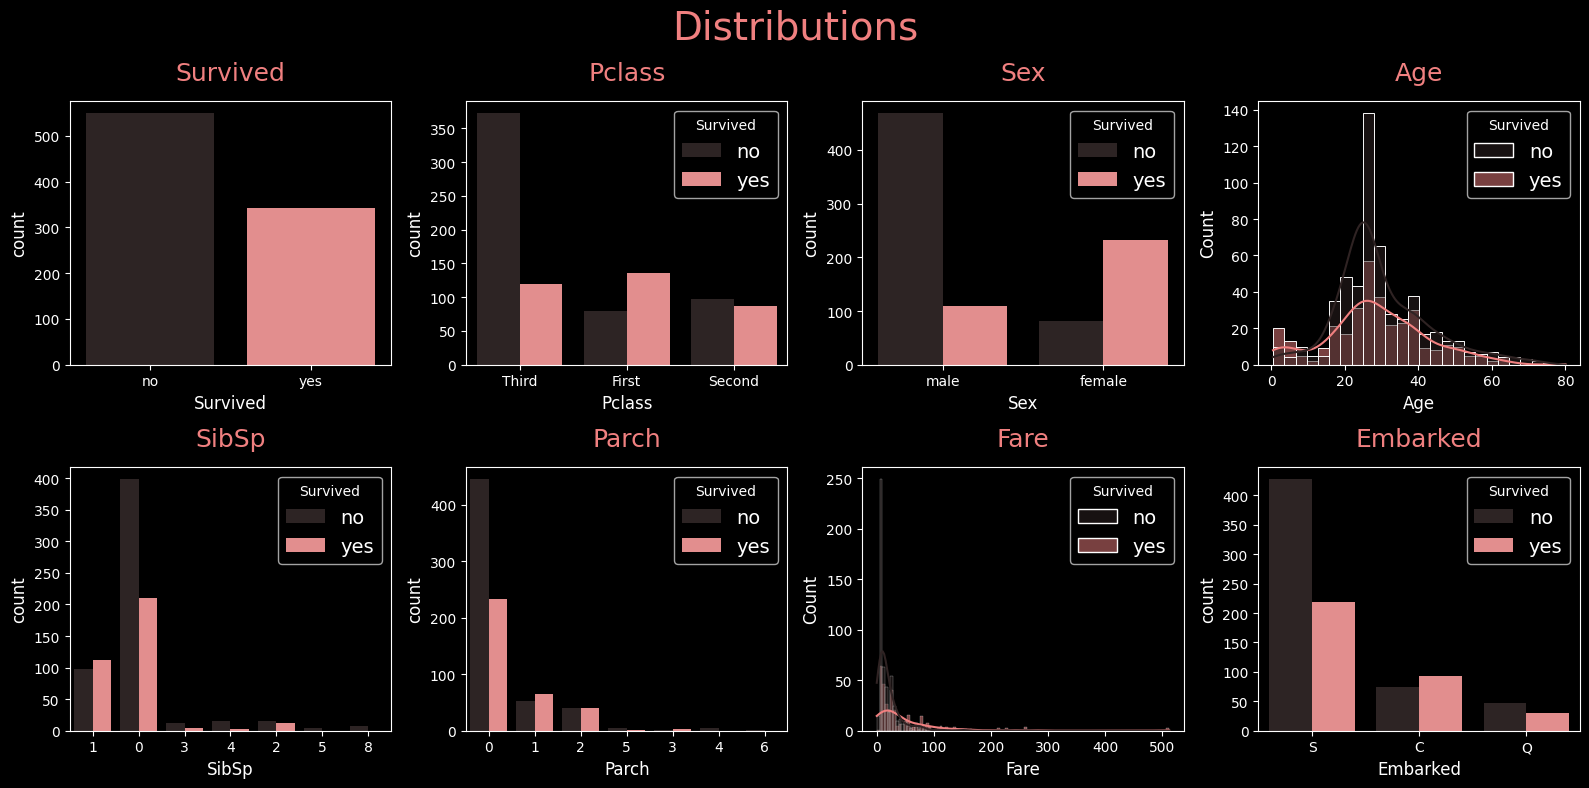

In [18]:
Plot.histplot(data=df, rows=2, columns=4, color="lightcoral", hue="Survived")

## Convert data into categorical features

In [19]:
df = pd.get_dummies(data=df, drop_first=True)
df = df.rename(columns={"Survived_yes": "Survived"})

## Split the data into features and target variable

In [20]:
X = df.drop(columns=["Survived"]).values
y = df["Survived"].values

## Split the data into training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize the features

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Compare custom models (Binary and Multinomial Logistic Regressions) with Sklearn Logistic Regression

In [23]:
b_lr_custom = BinaryRegression(learning_rate=0.01, iterations=10000)
ml_lr_custom = MultinomialRegression(learning_rate=0.01, iterations=10000)
lr_sklearn = LogisticRegression()

b_lr_custom.fit(X=X_train, y=y_train)
ml_lr_custom.fit(X=X_train, y=y_train)
lr_sklearn.fit(X=X_train, y=y_train)

y_pred_proba_custom_b = b_lr_custom.predict_proba(X=X_test)
y_pred_proba_custom_ml = ml_lr_custom.predict_proba(X=X_test)
y_pred_proba_sklearn = lr_sklearn.predict_proba(X=X_test)

y_pred_custom_b = b_lr_custom.predict(X=X_test)
y_pred_custom_ml = ml_lr_custom.predict(X=X_test)
y_pred_sklearn = lr_sklearn.predict(X=X_test)

## Compare probabilities and predictions

In [24]:
probabilities_predictions = {
    "binomial_probability_class_0" : y_pred_proba_custom_b[ :, 0],
    "binomial_probability_class_1" : y_pred_proba_custom_b[ :, 1],
    "multinomial_probability_class_0" : y_pred_proba_custom_ml[ :, 0],
    "multinomial_probability_class_1" : y_pred_proba_custom_ml[ :, 1],
    "sklearn_probability_class_0" : y_pred_proba_sklearn[ :, 0],
    "sklearn_probability_class_1" : y_pred_proba_sklearn[ :, 1],
    "binomial_prediction": y_pred_custom_b,
    "multinomial_prediction": y_pred_custom_ml,
    "sklearn_prediction": y_pred_sklearn
}

probabilities_predictions_df = pd.DataFrame(data=probabilities_predictions)

probabilities_predictions_df

,binomial_probability_class_0,binomial_probability_class_1,multinomial_probability_class_0,multinomial_probability_class_1,sklearn_probability_class_0,sklearn_probability_class_1,binomial_prediction,multinomial_prediction,sklearn_prediction
0,0.795039,0.204961,0.694308,0.305692,0.793829,0.206171,0,0.0,False
1,0.778243,0.221757,0.681787,0.318213,0.778040,0.221960,0,0.0,False
2,0.887607,0.112393,0.811174,0.188826,0.886826,0.113174,0,0.0,False
3,0.066792,0.933208,0.037084,0.962916,0.069119,0.930881,1,1.0,True
4,0.237250,0.762750,0.145551,0.854449,0.241520,0.758480,1,1.0,True
...,...,...,...,...,...,...,...,...,...
174,0.879591,0.120409,0.799805,0.200195,0.878793,0.121207,0,0.0,False
175,0.863327,0.136673,0.779357,0.220643,0.862980,0.137020,0,0.0,False
176,0.984569,0.015431,0.877214,0.122786,0.989969,0.010031,0,0.0,False
177,0.140898,0.859102,0.084989,0.915011,0.144561,0.855439,1,1.0,True


## Compare Loss with each iteration between Binomial and Multinomial Regressions

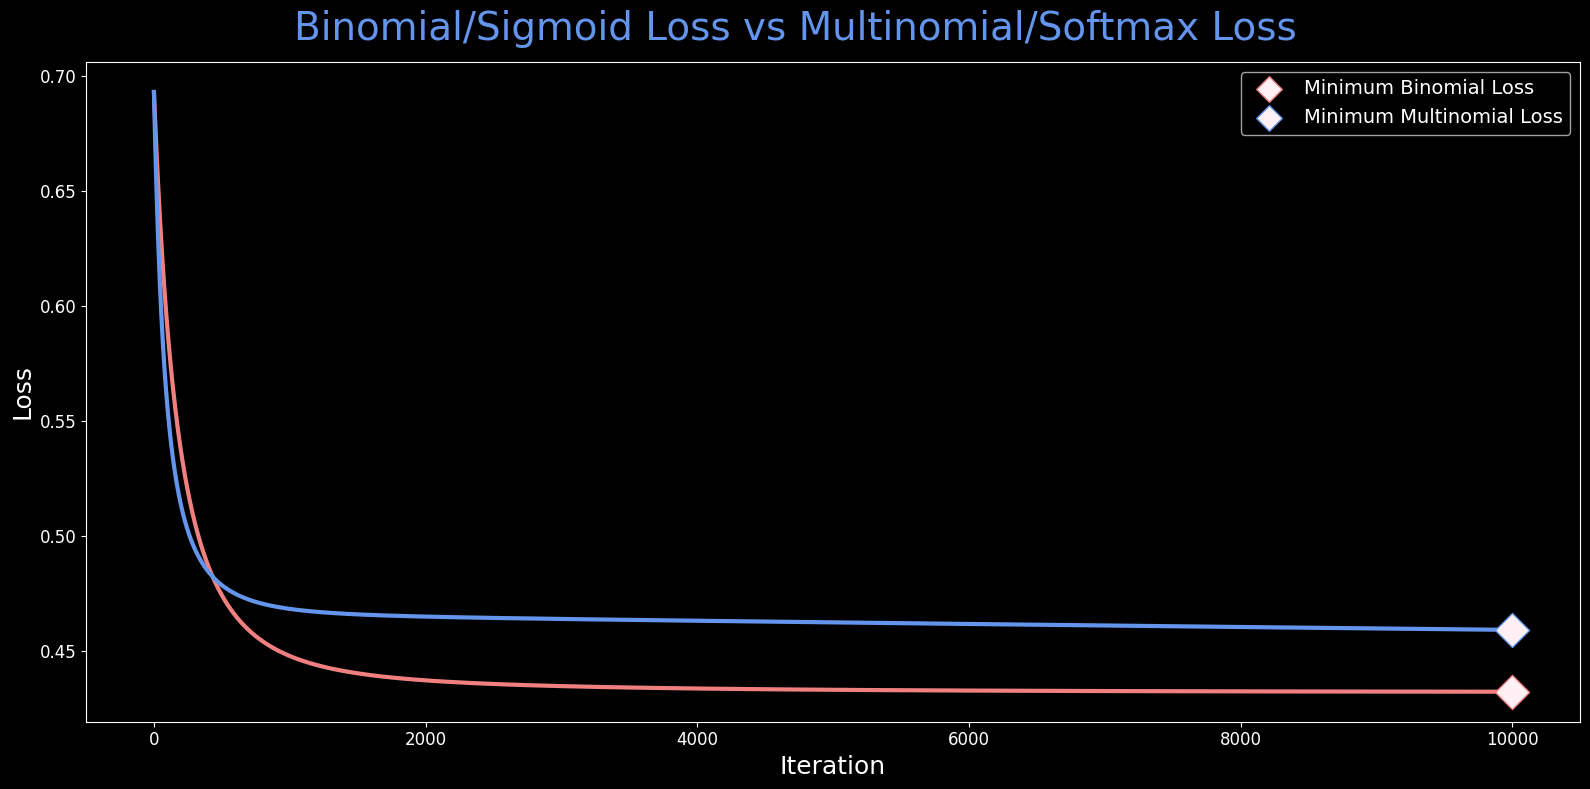

In [25]:
binomial_loss = b_lr_custom.loss_
multinomial_loss = ml_lr_custom.loss_

binomial_min = np.min(binomial_loss)
binomial_argmin = np.argmin(binomial_loss)
multinomial_min = np.min(multinomial_loss)
multinomial_argmin = np.argmin(multinomial_loss)

plt.suptitle(t="Binomial/Sigmoid Loss vs Multinomial/Softmax Loss", color="cornflowerblue")

plt.plot(range(len(binomial_loss)), binomial_loss, linewidth=3, color="lightcoral")
plt.plot(range(len(multinomial_loss)), multinomial_loss, linewidth=3, color="cornflowerblue")

plt.scatter(x=binomial_argmin, y=binomial_min, s=300, marker="D", edgecolors="lightcoral", 
            zorder=2, color="lavenderblush", label="Minimum Binomial Loss")
plt.scatter(x=multinomial_argmin, y=multinomial_min, s=300, marker="D", edgecolors="cornflowerblue", 
            zorder=2, color="lavenderblush", label="Minimum Multinomial Loss")

plt.xlabel(xlabel="Iteration", fontsize=18)
plt.ylabel(ylabel="Loss", fontsize=18)
plt.legend(markerscale=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Both Models decrease their losses but Binomial Regression shows better results (it's minimum loss is smaller) in 10000 iterations than Multinomial Regression for this dataset.

## Compare accuracies

In [26]:
accuracy_custom_b = accuracy_score(y_true=y_test, y_pred=y_pred_custom_b)
accuracy_custom_ml = accuracy_score(y_true=y_test, y_pred=y_pred_custom_ml)
accuracy_sklearn = accuracy_score(y_true=y_test, y_pred=y_pred_sklearn)

In [27]:
accuracies = {
    "binomial_accuracy": accuracy_custom_b,
    "multinomial_accuracy": accuracy_custom_ml,
    "sklearn_accuracy": accuracy_sklearn
}

accuracies_df = pd.DataFrame(data=accuracies, index=[0])
accuracies_df

,binomial_accuracy,multinomial_accuracy,sklearn_accuracy
0,0.793296,0.793296,0.793296


All models have the same accuracy. We will compare other metrics too

## Binomial Logistic Regression Metrics

### Custom Metrics

In [28]:
LogisticMetrics.classification_metrics_report(y_true=y_test, y_pred=y_pred_custom_b)

,precision,recall,f1_score,support
False,0.81,0.85,0.83,105.0
True,0.77,0.72,0.74,74.0
accuracy,,,0.79,179.0
macro_average,0.79,0.78,0.78,179.0


### Sklearn Metrics

In [29]:
print(classification_report(y_true=y_test, y_pred=y_pred_custom_b))

              precision    recall  f1-score   support

       False       0.81      0.85      0.83       105
        True       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Multinomial Logistic Regression Metrics

### Custom Metrics

In [30]:
LogisticMetrics.classification_metrics_report(y_true=y_test, y_pred=y_pred_custom_ml)

,precision,recall,f1_score,support
False,0.83,0.81,0.82,105.0
True,0.74,0.77,0.75,74.0
accuracy,,,0.79,179.0
macro_average,0.79,0.79,0.79,179.0


### Sklearn Metrics

In [31]:
print(classification_report(y_true=y_test, y_pred=y_pred_custom_ml))

              precision    recall  f1-score   support

       False       0.83      0.81      0.82       105
        True       0.74      0.77      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



## Sklearn Logistic Regression Metrics

### Custom Metrics

In [32]:
LogisticMetrics.classification_metrics_report(y_true=y_test, y_pred=y_pred_sklearn)

,precision,recall,f1_score,support
False,0.81,0.85,0.83,105.0
True,0.77,0.72,0.74,74.0
accuracy,,,0.79,179.0
macro_average,0.79,0.78,0.78,179.0


### Sklearn Metrics

In [33]:
print(classification_report(y_true=y_test, y_pred=y_pred_sklearn))

              precision    recall  f1-score   support

       False       0.81      0.85      0.83       105
        True       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Confusion Matrices 

### Custom Confusion Matrices

In [34]:
models = [
    {
        "title": "Binomial Regression",
        "y_pred": y_pred_custom_b,
        "y_pred_proba": y_pred_proba_custom_b
    },
    {
        "title": "Multinomial Regression",
        "y_pred": y_pred_custom_ml,
        "y_pred_proba": y_pred_proba_custom_ml
    },
    {
        "title": "Sklearn Regression",
        "y_pred": y_pred_sklearn,
        "y_pred_proba": y_pred_proba_sklearn
    }
]

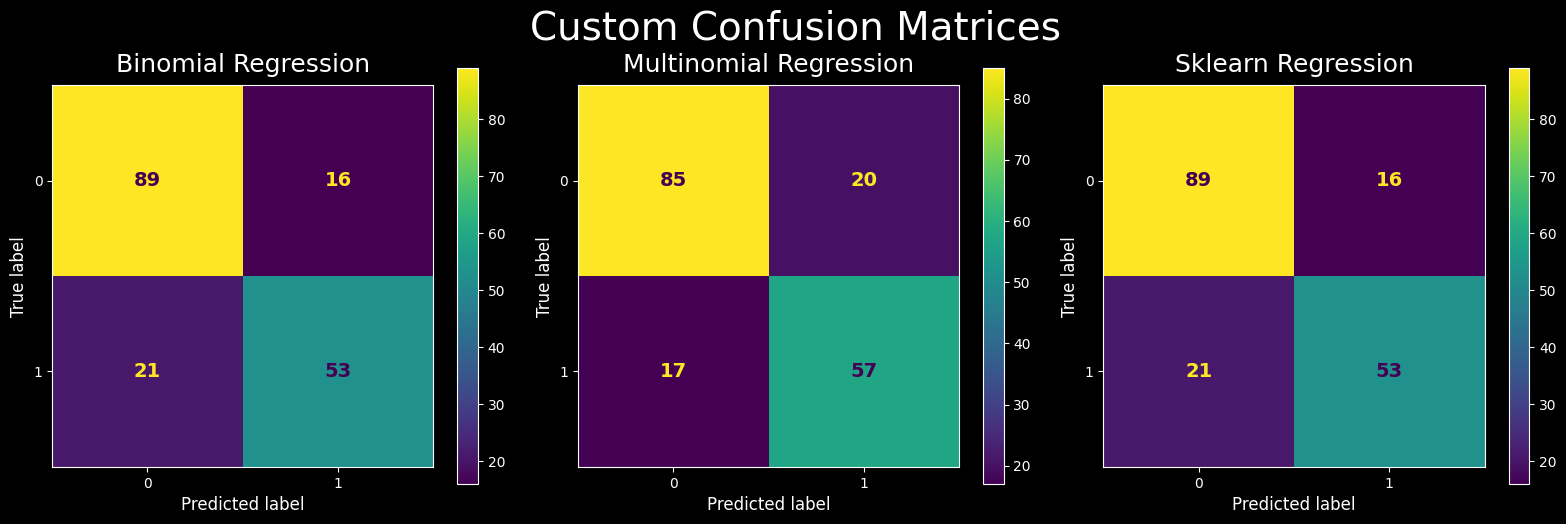

In [35]:
plt.figure(figsize=(16,5))

plt.suptitle(t="Custom Confusion Matrices")

for index, model in enumerate(models):
    plt.subplot(1, 3, index + 1)
    conf_matrix = LogisticMetrics.confusion_matrix(y_true=y_test, y_pred=model["y_pred"])
    cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    cm.plot(ax=plt.gca())
    plt.title(model["title"], pad=10)

    # Customize font properties
    for i in range(cm.text_.shape[0]):
        for j in range(cm.text_.shape[1]):
            text = cm.text_[i, j]
            text.set_fontsize(14)
            text.set_fontweight('bold')

plt.tight_layout()
plt.show()
    

### Sklearn Confusion Matrices

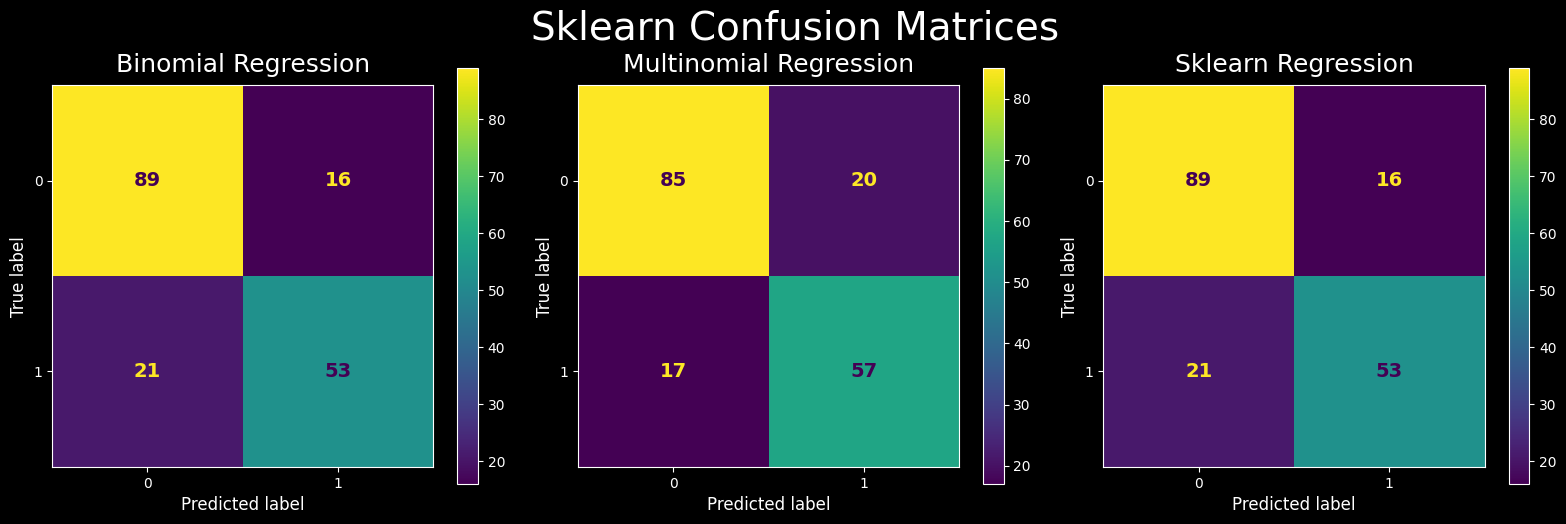

In [36]:
plt.figure(figsize=(16,5))

plt.suptitle(t="Sklearn Confusion Matrices")

for index, model in enumerate(models):
    plt.subplot(1, 3, index + 1)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=model["y_pred"])
    cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    cm.plot(ax=plt.gca())
    plt.title(model["title"], pad=10)

    # Customize font properties
    for i in range(cm.text_.shape[0]):
        for j in range(cm.text_.shape[1]):
            text = cm.text_[i, j]
            text.set_fontsize(14)
            text.set_fontweight('bold')

plt.tight_layout()
plt.show()
    

## ROC Curve

The **ROC (Receiver Operating Characteristic) Curve** is a graphical representation used to evaluate the performance of a binary classification model. It plots the **True Positive Rate (TPR)** (also known as sensitivity or recall) against the **False Positive Rate (FPR)** at various threshold settings. The ROC curve shows the trade-off between `sensitivity` and `specificity`, helping to assess the model’s ability to distinguish between classes. A perfect classifier has an ROC curve that passes through the top-left corner, and the closer the curve is to this point, the better the model performs.

We will compare ROC Curve for every model using sklearn implementation and my custom build RocCurvePlot class.

### Sklearn ROC Curve

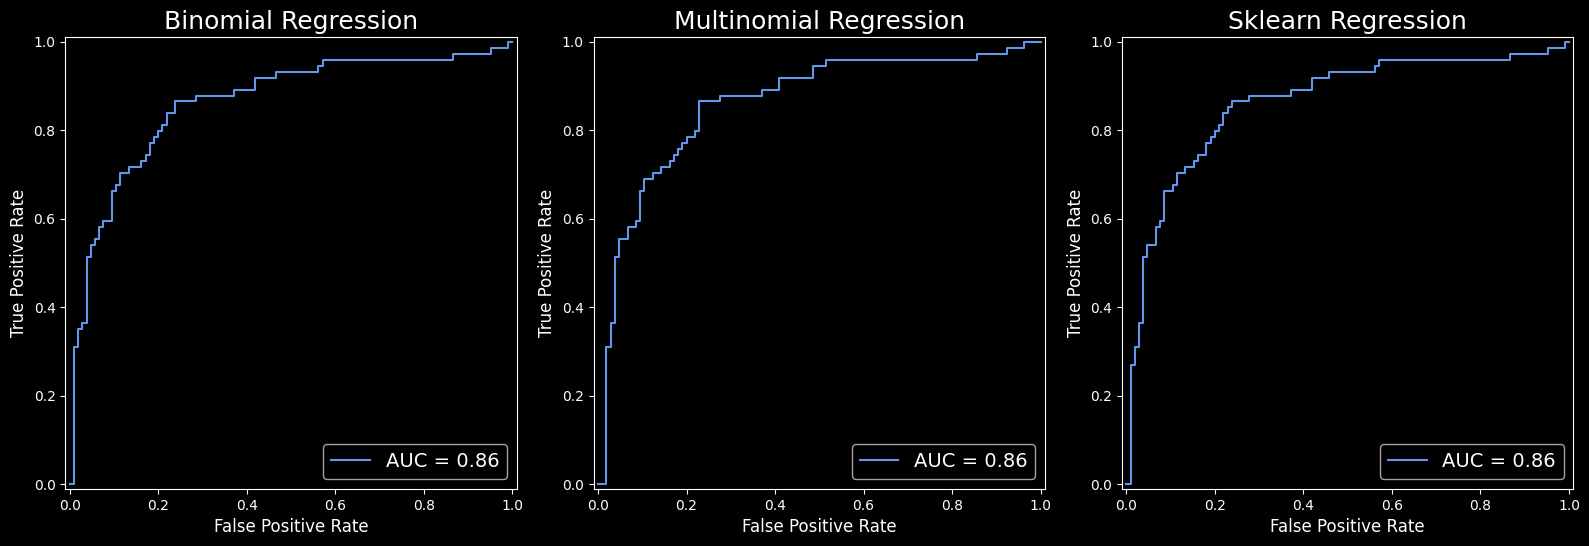

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))

for index, model in enumerate(models):
    y_score = model["y_pred_proba"][:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    ax[index].set_title(label=model["title"])

    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(ax=ax[index], color="cornflowerblue")

### Custom ROC Curve

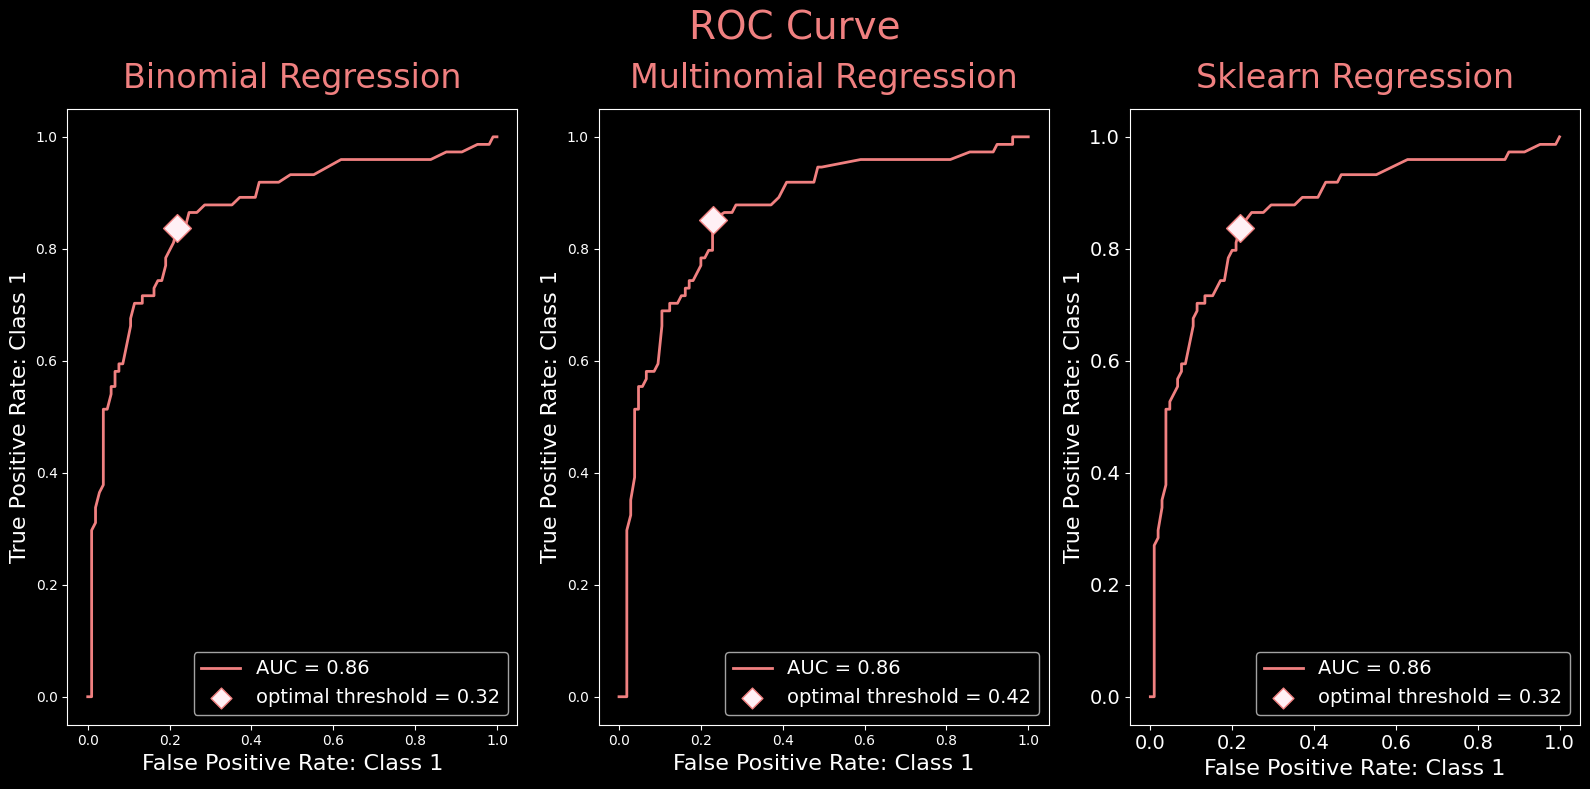

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))

for index, model in enumerate(models):
    y_score = model["y_pred_proba"][:,1]
    fpr, tpr, thresholds = RocCurvePlot.roc_curve(y_true=y_test, y_score=y_score)
    area_under_curve = RocCurvePlot.auc(fpr=fpr, tpr=tpr)
    optimal_index, optimal_threshold = RocCurvePlot.optimal_threshold(fpr=fpr, tpr=tpr, thresholds=thresholds)
    fpr_threshold = fpr[optimal_index]
    tpr_threshold = tpr[optimal_index]

    # update models with new thresholds
    model["optimal_threshold"] = optimal_threshold

    RocCurvePlot.plot(fpr=fpr, tpr=tpr, auc=area_under_curve, fpr_threshold=fpr_threshold, 
                    tpr_threshold=tpr_threshold, optimal_threshold=optimal_threshold, 
                    ax=ax[index], title=model["title"])

In custom build ROC Curve I am showing not only the area under the curve but also the optimal threshold for the dataset that will lead to better accuracy.

## Accuracy with optimal thresholds

In [39]:
for model in models:
    y_score = model["y_pred_proba"][:,1]
    y_pred_threshold = np.array([1 if score >= model["optimal_threshold"] else 0 for score in y_score])
    model["accuracy_threshold"] = accuracy_score(y_true=y_test, y_pred=y_pred_threshold)

In [40]:
accuracies = {}

for model in models:
    accuracies[f"{model["title"]} Accuracy"] = model["accuracy_threshold"]

accuracies_df = pd.DataFrame(data=accuracies, index=[0])
accuracies_df

,Binomial Regression Accuracy,Multinomial Regression Accuracy,Sklearn Regression Accuracy
0,0.804469,0.804469,0.804469


As we see changing the threshold helped slightly increase accuracy for all models.

## Conclusion

In this notebook, we explored and compared custom-built logistic regression models (both binomial and multinomial) with scikit-learn's implementation. We applied the models to the Titanic dataset and examined their performance using various metrics, such as accuracy, confusion matrices, ROC curves, and optimal thresholds.

Key takeaways:
1. **Data Preprocessing**: We handled missing values and transformed categorical features into numerical ones to make the data suitable for logistic regression models.
   
2. **Model Comparison**: All three models—custom binomial logistic regression, custom multinomial regression, and scikit-learn's logistic regression—showed similar accuracy. However, the custom models provided deeper insight into the behavior of binomial and multinomial losses, demonstrating that the binomial model achieved a lower loss than the multinomial one for this dataset.

3. **ROC Curve Analysis**: Both scikit-learn and the custom implementation of the ROC curve were used to evaluate the models. The ROC curves provided a visual understanding of each model's performance, and the area under the curve (AUC) values confirmed the models' ability to differentiate between classes.

4. **Optimal Thresholds**: The custom ROC curve analysis identified optimal thresholds for each model, improving their accuracy slightly. This demonstrated the importance of selecting the appropriate threshold for classification tasks, which can enhance model performance in real-world applications.

5. **Final Accuracy**: By recalculating predictions with optimal thresholds, all models experienced a small but meaningful increase in accuracy, highlighting the impact of threshold selection on model performance.

In conclusion, this notebook illustrates the importance of evaluating models not only through common metrics like accuracy but also by considering ROC curves and optimal thresholds. The insights gained through custom implementations provide a deeper understanding of logistic regression behavior, empowering better decision-making in classification tasks.